## Can You Predict Product Backorders?
Based on historical data predict backorder risk for products

Imputing "lead_time" may not be appropriate. It's quite likely that when lead_time is missing, it's missing for a reason and not at random, which means a mean/median imputation strategy may not be appropriate. 

You can probably decide by looking at the data: for example looking at the proportion of backordered products with vs. without a lead_time or the sales volume for products with vs. without a lead_time To trim down the size of the data set, I'd recommend sticking to the top products (for example trying to capture 60%-80%) of the total sales volume as opposed to only keeping non-zero sales. You can make the call for yourself by looking at the total # of products that remain when doing (a) no filtering (b) filtering out zero-sales products (c) capturing the majority of total sales. My guess is there'll be a big reduction in data from (b) to (c) for not much loss of fidelity.

To visualize the data, I recommend using a transformation that's appropriate for heavy-tailed data (like the natural log or square root) as opposed to normalizing the data to the 0-1 range. That sort of normalization can be great for fitting certain types of models (like SGD or SVMs) but isn't likely to help much with this sort of data visualization.
Ultimately my big suggestion is to keep things simple to start. Use your intuition, try looking at 1 piece of data at a time, and understand how it fits into the bigger puzzle. I'll talk you through how the facet plots and heatmap may be hurting you more than they're helping - but think about how you would answer a basic question like "Does lead_time affect the probability of a backorder?" How could we figure that out?

How could the supply chain process be improved?
-------------------------------------------------------------------
The business case study here would be to assess what aspects of the product creation are particularly sensitive to causing backorders. Here I'd start by evaluating:
How common are backorders?
Given that, how likely are backorders based on the part risk flags? And how prevalent are they?
What's the relationship between "potential_issue" and "pieces_past_due" are each represented by part risk flags or are they unrelated concepts?
What's the relationship between lead time and back orders?
Based on the answers to these questions you could recommend:
What aspects of the supply chain present the biggest risks?
Based on the risks, what would you recommend improving first?

How predictable are sales?
------------------------------------
If we *assume* (which may or may not be correct) that sales are independent of backorders, and backorders just slow delivery or increase cancellations, how predictable is demand?

We can create uncorrelated features by differencing the lagged features in the data set:
Features
Sales in months 1, 2, 3 =  "sales_3_month"
Sales in months 4, 5, and 6 =  "sales_6_month" -  "sales_3_month"
Sales in months 7, 8, and 9 =  "sales_9_month" -  "sales_6_month"
Based on these we can examine:
What proportion of products don't have more than a 10%, 20%, or 50% change over those time periods?
What proportion of products consistently trend up, or trend down over those time periods? 
What percentage flip? By how much?
Bonus: by differencing "sales_1_month" and "sales_3_month" how predictable are "sales_1_month" based on the previous time periods alone?


How common are backorders?
Given that, how likely are backorders based on the part risk flags? And how prevalent are they?
What's the relationship between "potential_issue" and "pieces_past_due" are each represented by part risk flags or are they unrelated concepts?
What's the relationship between lead time and back orders?

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import scipy.stats as stats
import seaborn as sns
from scipy import stats

In [17]:
train_data_=train_data


In [18]:
raw_data = pd.read_csv("Kaggle_Training_Dataset_v2.csv")

train_data = (raw_data
              .drop(raw_data.index[len(raw_data)-1])# drop invalid last row
              .replace(['Yes', 'No'], [1, 0]))   # make yes/no numeric

train_data.tail()

C:\Users\Hedi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687855,1407754,0.0,2.0,0.0,10.0,10.0,10.0,0.0,5.0,7.0,...,0.0,0.69,0.69,5.0,1,0,0,1,0,0
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,...,0.0,-99.00,-99.00,1.0,0,0,0,1,0,0
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,...,0.0,0.86,0.84,1.0,1,0,0,0,0,1
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,...,0.0,0.86,0.84,6.0,0,0,0,1,0,0
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,...,0.0,0.73,0.78,1.0,0,0,0,1,0,0


In [19]:
#data Information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687859
Data columns (total 23 columns):
sku                  1687860 non-null object
national_inv         1687860 non-null float64
lead_time            1586967 non-null float64
in_transit_qty       1687860 non-null float64
forecast_3_month     1687860 non-null float64
forecast_6_month     1687860 non-null float64
forecast_9_month     1687860 non-null float64
sales_1_month        1687860 non-null float64
sales_3_month        1687860 non-null float64
sales_6_month        1687860 non-null float64
sales_9_month        1687860 non-null float64
min_bank             1687860 non-null float64
potential_issue      1687860 non-null int64
pieces_past_due      1687860 non-null float64
perf_6_month_avg     1687860 non-null float64
perf_12_month_avg    1687860 non-null float64
local_bo_qty         1687860 non-null float64
deck_risk            1687860 non-null int64
oe_constraint        1687860 non-null int64
ppap_risk           

In [20]:
#data description
train_data.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,...,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,...,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01,2.295706e-01,1.451542e-04,1.207648e-01,9.638086e-01,4.330928e-04,6.690721e-03
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,...,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01,4.205568e-01,1.204713e-02,3.258538e-01,1.867661e-01,2.080638e-02,8.152275e-02
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,...,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,...,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,...,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [21]:
#missing values in product
train_data.sku.isnull().sum()

0

In [22]:
#missing value 
train_data.isnull().sum()

sku                       0
national_inv              0
lead_time            100893
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

In [23]:
prob=len(train_data[train_data.went_on_backorder==1])/len(train_data.sku)
print((prob*100),'%')


0.6690720794378681 %


check the missing data in lead time to replace it or not?
1. Proportion of orders that “went_on_backorder” for missing lead_time records
2. Proportion of orders that “went_on_backorder” for non-null lead_time records

In [24]:
float('NaN')
def my_tilde(x):
    return -x - 1


l = np.array([0, 1, 2, 3])
print(l[0])
print(~l)
~np.isnan(float('NaN'))

0
[-1 -2 -3 -4]


False

In [25]:
n_null_leadTime = train_data[train_data['lead_time'].isnull()].shape[0]
print(n_null_leadTime)
n_non_null_leadTime = train_data[train_data['lead_time'].notnull()].shape[0]
print(n_non_null_leadTime)
n_null_leadTime_backorders =sum(train_data[np.isnan(train_data["lead_time"])]["went_on_backorder"])
print (n_null_leadTime_backorders)
n_non_null_leadTime_backorders = sum(train_data[pd.notnull(train_data["lead_time"])]["went_on_backorder"])
print  (n_non_null_leadTime_backorders)

null_leadTime_backorder_ratio = n_null_leadTime_backorders / float(n_null_leadTime)
non_null_leadTime_backorder_ratio = n_non_null_leadTime_backorders / float(n_non_null_leadTime)
print('Proportion of orders that “went_on_backorder” for no missing lead_time records:',non_null_leadTime_backorder_ratio * 100)
print('Proportion of orders that “went_on_backorder” for missing lead_time records:', null_leadTime_backorder_ratio * 100)


100893
1586967
324
10969
Proportion of orders that “went_on_backorder” for no missing lead_time records: 0.691192696508
Proportion of orders that “went_on_backorder” for missing lead_time records: 0.321132288662


Based on the proportion of orders for missing lead_time_ time of orders went backorder, we can see that the result is 50% less 
than proportion of lead time without missing values, and our total went backorder proportion is around 0.66 and it is close to 
proportion of orders that went back order for non missing values. 
Therefore ....
below we can see the lead time plot and went_backorder type. from the plot we see that 

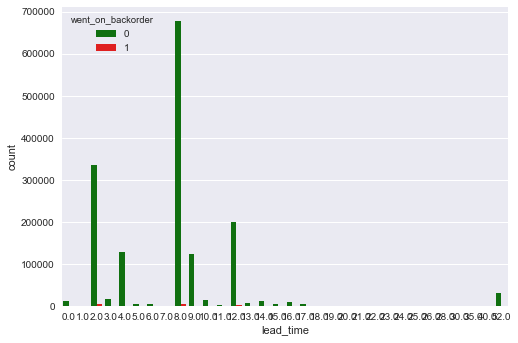

In [28]:
#coorelation between lead time and wen on backorder
scores = train_data[['lead_time','went_on_backorder']]
sns.countplot(x="lead_time", hue="went_on_backorder", data=scores, palette={1: "r", 0: "g"})
plt.show()

[[ 1.        -0.5420028]
 [-0.5420028  1.       ]]


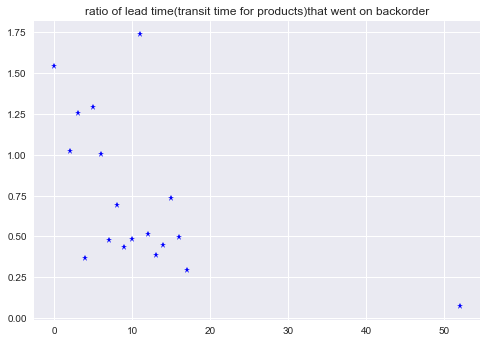

[1.5412425078489203, 1.0245938079797985, 1.2551528948501816, 0.36954339995487684, 1.2900024807740016, 1.006523765144455, 0.4784688995215311, 0.6954115153345275, 0.43348510703685433, 0.48618940248027059, 1.7367458866544789, 0.51276915373059584, 0.38852913968547642, 0.44599573395384917, 0.73452256033578167, 0.49756869840551843, 0.29231995748073347, 0.073058147643874735]


,lead_b,lead_n
0.0,162.0,10349
2.0,3457.0,333945
3.0,204.0,16049
4.0,475.0,128062
5.0,52.0,3979
6.0,54.0,5311
7.0,1.0,208
8.0,4744.0,677442
9.0,536.0,123113
10.0,69.0,14123


In [243]:
import decimal
b=train_data[['went_on_backorder','lead_time']]
backorder=b[b.went_on_backorder==1]
no_backorder=b[b.went_on_backorder==0]
lead_b=backorder.lead_time.value_counts()
lead_n=no_backorder.lead_time.value_counts()
c=[]
df1 = pd.DataFrame(
    {
     'lead_b': lead_b,
     'lead_n':lead_n
    })

df1=df1[['lead_b','lead_n']].dropna()


for i in range(0,len(df1)):
    backorder_ratio=(df1.lead_b.iloc[i])/(df1.lead_n.iloc[i]+df1.lead_b.iloc[i])
    backorder_ratio=backorder_ratio*100
    c.append(backorder_ratio)


print(np.corrcoef(df1.index.values,c))

plt.plot(df1.index.values,c,"*",color="blue")
plt.title('ratio of lead time(transit time for products)that went on backorder')
#plt.plot(np.array(range(len(c))) * 0.25, c,".")
plt.show()
print(c)
df1


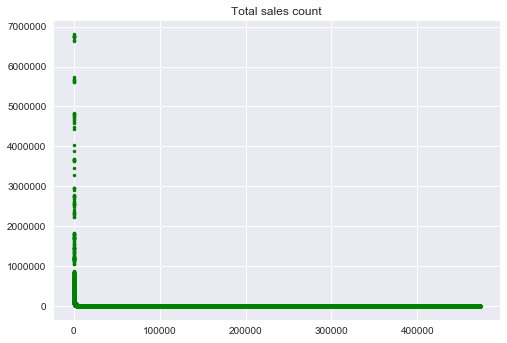

In [328]:
sales_data=train_data
total_sales=(sales_data.sales_1_month+sales_data.sales_3_month+sales_data.sales_6_month+sales_data.sales_9_month)
sales_data['total_sales']=total_sales
reduced_data=sales_data.sort_values('total_sales',ascending = False)

plt.plot(np.array(range(len(reduced_data))) * 0.28, reduced_data.total_sales,".",color="green")
plt.title('Total sales count')
plt.show()


[[ 1.          0.79973589]
 [ 0.79973589  1.        ]]


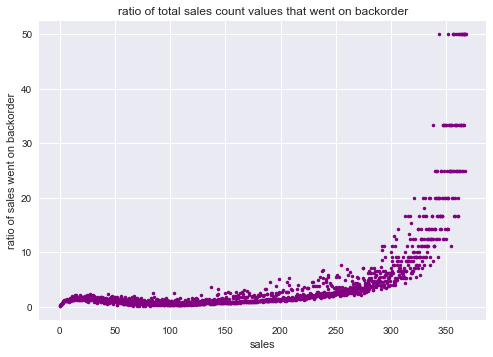

In [329]:
#correlation between sales and backorder

sw=reduced_data[['went_on_backorder','total_sales']]
backorder_sales=sw[sw.went_on_backorder==1]
no_backorder_sales=sw[sw.went_on_backorder==0]
sales_b=backorder_sales.total_sales.value_counts()
sales_n=no_backorder_sales.total_sales.value_counts()
g=[]
df2 = pd.DataFrame(
    {
     'sales_b': sales_b,
     'sales_n':sales_n
    })

df2=df2[['sales_b','sales_n']].dropna()


for i in range(0,len(df2)):
    backorder_ratio=(df2.sales_b.iloc[i])/(df2.sales_n.iloc[i]+df2.sales_b.iloc[i])
    backorder_ratio=backorder_ratio*100
    g.append(backorder_ratio)


print(np.corrcoef(df2.index.values,g))
plt.plot(np.array(range(len(g))) * 0.25, g,".",color='purple')
plt.title('ratio of total sales count values that went on backorder')
plt.xlabel('sales')
plt.ylabel('ratio of sales went on backorder')
plt.show()


Data reduction by capture 60% of the total sales volume.

1846561168.0
1107936700.8


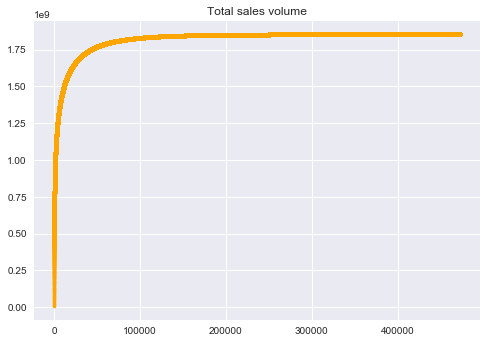

In [395]:
sales_volume =np.cumsum(sample_data.total_sales)
print(sales_volume[len(sales_volume)-1])
print(0.6 * sales_volume[len(sales_volume)-1])
plt.plot(np.array(range(len(sample_data))) * 0.28, sales_volume,".",color="orange")
plt.title('Total sales volume')

plt.show()

1107936700.8
1846561168.0


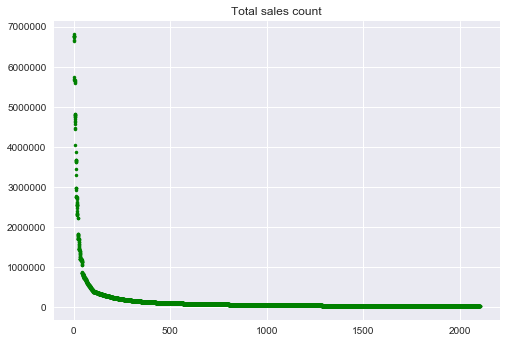

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7509 entries, 1416050 to 210101
Data columns (total 25 columns):
sku                  7509 non-null object
national_inv         7509 non-null float64
lead_time            7327 non-null float64
in_transit_qty       7509 non-null float64
forecast_3_month     7509 non-null float64
forecast_6_month     7509 non-null float64
forecast_9_month     7509 non-null float64
sales_1_month        7509 non-null float64
sales_3_month        7509 non-null float64
sales_6_month        7509 non-null float64
sales_9_month        7509 non-null float64
min_bank             7509 non-null float64
potential_issue      7509 non-null int64
pieces_past_due      7509 non-null float64
perf_6_month_avg     7509 non-null float64
perf_12_month_avg    7509 non-null float64
local_bo_qty         7509 non-null float64
deck_risk            7509 non-null int64
oe_constraint        7509 non-null int64
ppap_risk            7509 non-null int64
stop_auto_buy        7509 non-null

In [400]:
a=sample_data
volume_perc=0.6 * sales_volume[len(sales_volume)-1]
print(volume_perc)
print(sales_volume[len(sales_volume)-1])
a['sales_volume']=sales_volume

a=a.sort_values('sales_volume',ascending = True)
a=a[a['sales_volume']<=volume_perc]

a=a.sort_values('total_sales',ascending = False)
plt.plot(np.array(range(len(a))) * 0.28, a.total_sales,".",color="green")
plt.title('Total sales count')
plt.show()
a.info()

So with capturing 60 % total sales volume ,data is reduced to 7509 rows.

In [303]:
dx = 0.5
x=np.arange(-1, 1, dx)
f = np.sqrt(1 - x * x)
print('x=', x)
print('f = ', f)
print('cumsum = ', np.cumsum(f))
print(np.cumsum(f)[len(x) - 1])
print(0.8 * np.cumsum(f)[len(x) - 1])

x= [-1.  -0.5  0.   0.5]
f =  [ 0.         0.8660254  1.         0.8660254]
cumsum =  [ 0.          0.8660254   1.8660254   2.73205081]
2.73205080757
2.18564064606


50.2466725085


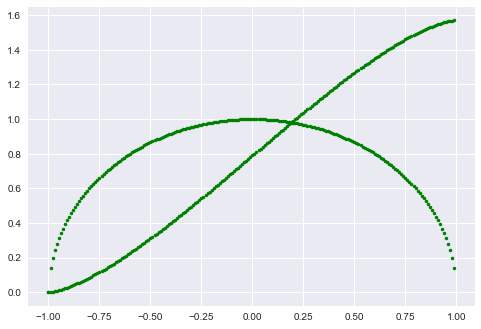

In [295]:
x=np.arange(-1, 1, 0.01)
plt.plot(x, np.sqrt(1 - x * x),".",color="green")
plt.plot(x, np.cumsum(np.sqrt(1 - x * x))*0.01,".",color="green")
circle=np.cumsum(np.sqrt(1 - x * x))
print (0.32 * circle[len(circle)-1])
plt.show()

In [234]:
sample_data=reduced_data.drop('total_sales', 1)

How common are backorders? Given that, how likely are backorders based on the part risk flags? 
And how prevalent are they? 
What is the relationship between "potential_issue" and "pieces_past_due" are each represented by part 
risk flags or are they unrelated concepts? What's the relationship between lead time and back orders? 
Based on the answers to these questions you could recommend: What aspects of the supply chain present the biggest risks? 
Based on the risks, what would you recommend improving first?
    
potential_issue - Source issue for part identified

pieces_past_due - Parts overdue from source

local_bo_qty - Amount of stock orders overdue

deck_risk - Part risk flag

oe_constraint - Part risk flag

ppap_risk - Part risk flag

In [235]:
print(np.corrcoef(sample_data.potential_issue,sample_data.pieces_past_due))

[[ 1.          0.00331913]
 [ 0.00331913  1.        ]]


In [220]:
from scipy.stats import boxcox
from sklearn import preprocessing
from scipy.stats import skew
from scipy.stats import boxcox

#The next line uses scale method from scikit-learn to transform the distribution 
#This will not impact Skewness Statistic calculation
#We have included this for sake of completion
#Note that we changed the following line to process the square roots instead of actuals

norm_col=['forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month', 'min_bank',
                   'loc.32al_bo_qty', 'pieces_past_due', 'sales_1_month', 
                   'sales_3_month', 'sales_6_month', 'sales_9_month']
for col in norm_col:
    sample_data[col] = preprocessing.scale(boxcox(sample_data[col]+1)[0])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
sample_data.hist(figsize=(12,12), alpha=0.75,color='green', grid=False)
plt.show()

KeyError: 'loc.32al_bo_qty'

[[ 1.        -0.4188246]
 [-0.4188246  1.       ]]


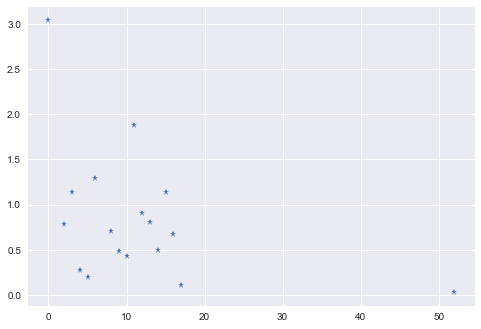

[3.0406852248394003, 0.77932312721647379, 1.144492131616595, 0.27033876826898706, 0.19782393669634024, 1.2917115177610334, 0.70328867374141579, 0.48211781206171106, 0.4330566582461205, 1.8796992481203008, 0.9036019154694982, 0.80285459411239968, 0.5008347245409015, 1.1351909184726523, 0.67114093959731547, 0.11210762331838565, 0.028935185185185182]


,lead_b,lead_n
0.0,71.0,2264
2.0,534.0,67987
3.0,32.0,2764
4.0,64.0,23610
5.0,4.0,2018
6.0,24.0,1834
8.0,1232.0,173945
9.0,55.0,11353
10.0,12.0,2759
11.0,10.0,522


In [221]:
import decimal
d=sample_data[['went_on_backorder','lead_time']]
backorder=d[d.went_on_backorder==1]
no_backorder=d[d.went_on_backorder==0]
lead_b=backorder.lead_time.value_counts()
lead_n=no_backorder.lead_time.value_counts()
g=[]
df1 = pd.DataFrame(
    {
     'lead_b': lead_b,
     'lead_n':lead_n
    })

df1=df1[['lead_b','lead_n']].dropna()


for i in range(0,len(df1)):
    backorder_ratio=(df1.lead_b.iloc[i])/(df1.lead_n.iloc[i]+df1.lead_b.iloc[i])
    backorder_ratio=backorder_ratio*100
    g.append(backorder_ratio)

print(np.corrcoef(df1.index.values,g))

plt.plot(df1.index.values,g,"*")
#plt.plot(np.array(range(len(c))) * 0.25, c,".")
plt.show()
print(g)
df1

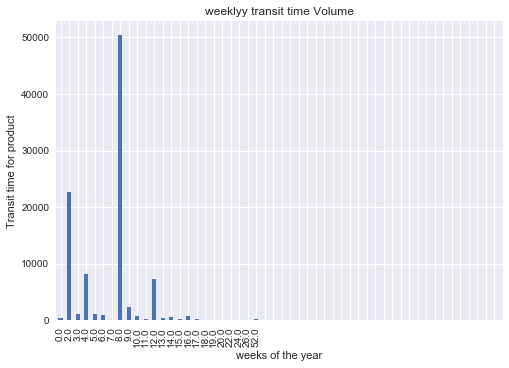

In [14]:
weeksdist=reduced_data['lead_time'].value_counts().sort_index()
weeksdist.plot(kind='bar')
_=plt.xlabel('weeks of the year')
_=plt.ylabel('Transit time for product')
_=plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52])
plt.title('weeklyy transit time Volume')
plt.show()

In [15]:
weeksdist.idxmax()

8.0

?????????????????the highest transit time is at 8 weeks which was more than 50000 items. 

We can create uncorrelated features by differencing the lagged features in the data set: 
    Features Sales in months 1, 2, 3 = "sales_3_month"
    Sales in months 4, 5, and 6 = "sales_6_month" - "sales_3_month" Sales in months 7, 8, 
    and 9 = "sales_9_month" - "sales_6_month" Based on these we can examine:
        What proportion of products don't have more than a 10%, 20%, or 50% 
        change over those time periods? What proportion of products consistently trend up, or trend down over those time periods? 
        What percentage flip? By how much? Bonus: by differencing "sales_1_month" and 
            "sales_3_month" how predictable are "sales_1_month" based on the previous time periods
        alone?

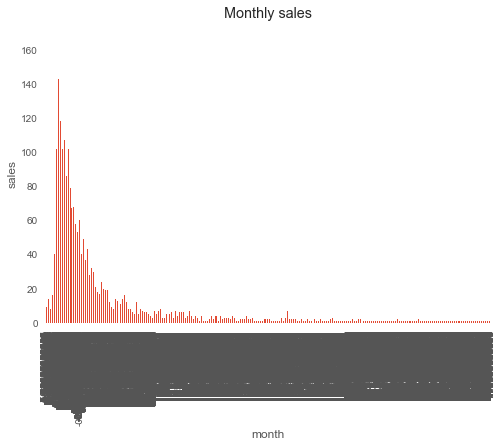

1602060    4.723869
1416050    4.723346
174594     4.712074
994488     4.709578
842690     4.719264
623334     4.715523
384211     4.718109
1130061    4.704512
96294      4.706376
23637      4.623466
Name: sales_3_month, dtype: float64

In [85]:
rd=reduced_data
sales123=rd['sales_3_month']
sales456=rd.sales_6_month-rd.sales_3_month
sales789=rd.sales_9_month-rd.sales_6_month
salesPlot=sales123.value_counts().sort_index()
salesPlot.plot(kind='bar')
_=plt.xlabel('month')
_=plt.ylabel('sales')
plt.title('Monthly sales')
plt.show()
sales123.head(10)


In [93]:
s=sales123.groupby(rd['sku']).value_counts().sort_values()
s.head(50)

sku      sales_3_month
1111598  -0.423474        1
2254399   1.006351        1
2254393   0.341285        1
2254391  -0.174362        1
2254390  -0.691405        1
2254382   0.402245        1
2254372  -0.539962        1
2254353  -0.010895        1
2254347  -0.578784        1
2254339  -1.271406        1
2254446   0.564724        1
2254335  -0.419783        1
2254324  -0.350761        1
2254316   0.083074        1
2254312  -1.334143        1
2254305   1.386315        1
2254300  -0.132424        1
2254277   0.707799        1
2254262  -0.914092        1
2254258   0.147884        1
2254255  -0.870461        1
2254330  -0.585423        1
2254253   2.042399        1
2254496  -0.018935        1
2254533   0.022716        1
2254818   0.776752        1
2254817   0.021617        1
2254809  -0.630986        1
2254795  -1.736033        1
2254768   0.014993        1
2254766   0.746619        1
2254760  -0.478811        1
2254746  -0.350761        1
2254724   0.189323        1
2254503  -0.814383       

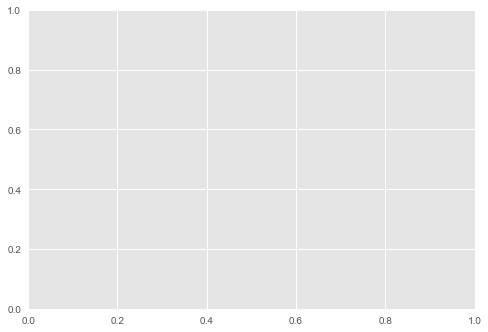

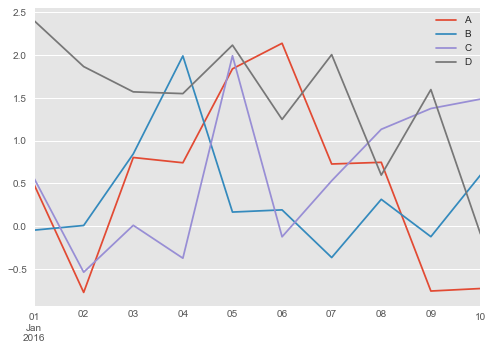

In [83]:
import matplotlib
matplotlib.style.use('ggplot')

saleslist=[sales123,sales456,sales789]
ts = pd.Series(saleslist, index=pd.date_range('1/1/2016', periods=10))




df = pd.DataFrame(np.random.randn(10, 4), index=ts.index, columns=list('ABCD'))


plt.figure(); 
df.plot();
plt.show()




In [ ]:
from scipy.stats import boxcox
from sklearn import preprocessing
from scipy.stats import skew
#The next line uses scale method from scikit-learn to transform the distribution 
#This will not impact Skewness Statistic calculation
#We have included this for sake of completion
#Note that we changed the following line to process the square roots instead of actuals
AirTime = preprocessing.scale(np.sqrt(reduced_data['sales_9_month'])) 

#Note that we shift the values by 1 to get rid of zeros
AirTimeBoxCox = preprocessing.scale(boxcox(reduced_data['sales_9_month']+1)[0])
AirTimeOrig = preprocessing.scale(reduced_data['sales_9_month'])

#Next We calculate Skewness using skew in spicy.stats
skness = skew(AirTime)
sknessBoxCox = skew(AirTimeBoxCox)
sknessOrig = skew(AirTimeOrig)


#We draw the histograms 
figure = plt.figure()
figure.add_subplot(131)   
plt.hist(AirTime,facecolor='red',alpha=0.75) 
plt.xlabel("sales - Transformed(Using Sqrt)") 
plt.title("sales Histogram") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skness)) 

figure.add_subplot(132) 
plt.hist(AirTimeBoxCox,facecolor='blue',alpha=0.75) 
plt.xlabel("sales - Using BoxCox Transformation") 
plt.title("sales Histogram - Un-Skewed(BoxCox)") 
plt.text(2,100000,"Skewness: {0:.2f}".format(sknessBoxCox))

figure.add_subplot(133) 
plt.hist(AirTimeOrig,facecolor='green',alpha=0.75) 
plt.xlabel("sales - Based on Original Flight Times") 
plt.title("sales Histogram - Right Skewed") 
plt.text(2,100000,"Skewness: {0:.2f}".format(sknessOrig))
plt.show()


In [33]:
from scipy.stats import boxcox
from sklearn import preprocessing
from scipy.stats import skew
#The next line uses scale method from scikit-learn to transform the distribution 
#This will not impact Skewness Statistic calculation
#We have included this for sake of completion
#Note that we changed the following line to process the square roots instead of actuals

norm_col=['forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month', 'min_bank',
                   'local_bo_qty', 'pieces_past_due', 'sales_1_month', 
                   'sales_3_month', 'sales_6_month', 'sales_9_month']
for col in norm_col:
    reduced_data[col] = preprocessing.scale(boxcox(reduced_data[col]+1)[0])
    

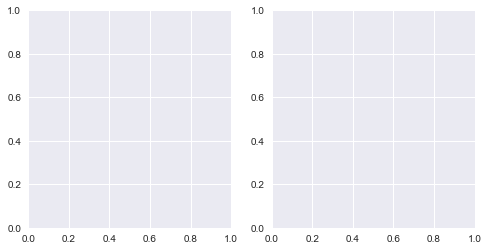

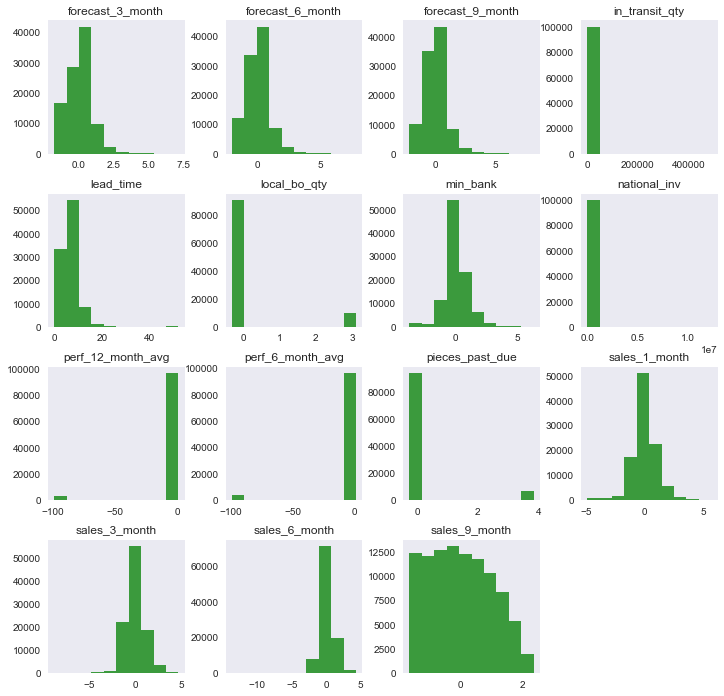

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
reduced_data.hist(figsize=(12,12), alpha=0.75,color='green', grid=False)
plt.show()

In [ ]:
reduced_data=

### Data Preprocessing
#### Imputing missing values

Lead time has many missing values which I am going to replace it with mean of lead time and also there is a null row for all columns which I drop that column.

In [ ]:
from sklearn.preprocessing import Imputer
train_data['lead_time']=Imputer(strategy='mean').fit_transform(train_data['lead_time'].values.reshape(-1,1))
#another way is using fillna
#train_data['lead_time'] = train_data['lead_time'].fillna(train_data['lead_time'].mean())

In [ ]:
train_data=train_data.dropna()
train_data.isnull().sum().sum()

In [ ]:
#replace 'yes' and 'No' to 0,1
train_data=train_data.replace(['Yes', 'No'], [1, 0])

In [ ]:
#replace missing values in performance 
imp=Imputer(missing_values=-99,strategy='mean')
for data in ['perf_6_month_avg','perf_12_month_avg']:
  train_data[data] = imp.fit_transform(train_data[data].values.reshape(-1, 1))

### Data reduction

In [ ]:
sales=['sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month']
forecast=['forecast_3_month','forecast_6_month', 'forecast_9_month']
for col in sales:
    #miss_sales=sml_data[sml_data[col]==0]
    for col2 in forecast:
    #miss_forecast=sml_data[sml_data[col2]==0]
#if (miss_sales & miss_forecast ):
    #print(len())
     new_data=train_data[(train_data[col2]!=0) & (train_data[col]!=0)]
    #new_data = train_data.loc[(train_data["forecast_3_month"]>0)&(train_data["sales_9_month"]>0)]
new_data.head(5)
new_data.describe()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
new_data.hist(figsize=(12,12), alpha=0.5, grid=False)
plt.show()

### Normalization
The simplest method is rescaling the range of features to scale the range in [0, 1] or [−1, 1]. 

$$x_{normalized} = \frac{x-x_{min}}{x_{max}-x_{min}}.$$


In [ ]:
from sklearn.preprocessing import normalize

norm_col=['forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month', 'min_bank',
                   'local_bo_qty', 'pieces_past_due', 'sales_1_month', 
                   'sales_3_month', 'sales_6_month', 'sales_9_month']

new_data[norm_col]=normalize(new_data[norm_col],axis=1)
new_data.head()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
new_data.hist(figsize=(12,12), alpha=0.5,color='red', grid=False)
plt.show()

### Standardization
Stardardization is centering the data around 0 and scale with respect to the standard deviation:

$$x_{standardized} = \frac{x-\mu}{\sigma},$$
where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset, respectively.

In [ ]:
from sklearn.preprocessing import scale
new_data['lead_time']=scale(new_data['lead_time'])
#plt.hist(new_data.lead_time,alpha=0.5)
#plt.show()

### Data Visualizarion:
Heatmap shows coroolation between data.
which features have correlation with went back order?


In [ ]:
sns.heatmap(new_data.corr(), square=True, cmap='RdYlGn')
plt.show()

1. How common are back-orders?

2. Given that, how likely are backorders based on the part risk flags? And how prevalent are they?

3. What's the relationship between "potential_issue" and "pieces_past_due" are each represented by part risk flags or are they unrelated concepts?

4. What's the relationship between lead time and back orders?

In [25]:
categories=new_data.loc[:, new_data.columns != 'sku']
categories=categories.select_dtypes(include=['int64'])

from seaborn import countplot, set_style,despine, axes_style
from matplotlib.pyplot import show
from IPython.display import display
from pandas import DataFrame

def category_analysis(series):
    
    set_style("whitegrid")
    
    with axes_style({'axes.grid': False}):
        cp = countplot(series)
        cp.set_title(cp.get_xlabel())
        cp.set_xlabel("",visible=False)
        despine()
    
    show()
    display(DataFrame(series.value_counts().apply(lambda x: x / len(new_data) * 100).round(2)).T)
    

NameError: name 'new_data' is not defined

In [26]:
for category in categories:
    category_analysis(new_data[category])

NameError: name 'categories' is not defined

In [27]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(new_data.loc[(new_data['went_on_backorder'] == 0),'forecast_9_month'] , color='b',shade=True, label='no backorder')
ax=sns.kdeplot(new_data.loc[(new_data['went_on_backorder'] == 1),'forecast_9_month'] , color='r',shade=True, label='backorder')
plt.title('Forecast sales for the next 9 months - backorder V.S. No backorder')
plt.show()

NameError: name 'new_data' is not defined

In [28]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(new_data.loc[(new_data['went_on_backorder'] == 0),'forecast_3_month'] , color='b',shade=True, label='no backorder')
ax=sns.kdeplot(new_data.loc[(new_data['went_on_backorder'] == 1),'forecast_3_month'] , color='r',shade=True, label='backorder')
plt.title('Forecast sales for the next 3 months - backorder V.S. No backorder')
plt.show()

NameError: name 'new_data' is not defined

In [29]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(new_data.loc[(new_data['went_on_backorder'] == 0),'perf_12_month_avg'] , color='b',shade=True, label='no backorder')
ax=sns.kdeplot(new_data.loc[(new_data['went_on_backorder'] == 1),'perf_12_month_avg'] , color='r',shade=True, label='backorder')
plt.title('Source performance for prior 12 month period')
plt.show()

NameError: name 'new_data' is not defined

In [30]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(new_data.loc[(new_data['deck_risk'] == 0),'sales_9_month'] , color='b',shade=True, label='Part risk flag=0')
ax=sns.kdeplot(new_data.loc[(new_data['deck_risk'] == 1),'sales_9_month'] , color='r',shade=True, label='Part risk flag=1')
plt.title('Part risk flag')
plt.show()

NameError: name 'new_data' is not defined

In [31]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(new_data.loc[(new_data['went_on_backorder'] == 0),'lead_time'] , color='b',shade=True, label='no backorder')
ax=sns.kdeplot(new_data.loc[(new_data['went_on_backorder'] == 1),'lead_time'] , color='g',shade=True, label='backorder')
plt.title('lead time - backorder V.S. No backorder')
plt.show()

NameError: name 'new_data' is not defined

In [32]:
data = new_data[['went_on_backorder','lead_time']]
correlation = data.corr(method='pearson')
correlation

NameError: name 'new_data' is not defined

In [ ]:
g = sns.lmplot(x='forecast_9_month', y='local_bo_qty', hue='went_on_backorder',
               truncate=True, size=5, data=new_data)

# Use more informative axis labels than are provided by default
g.set_axis_labels("forecast sales for next 9 month", "Amount of stock orders overdue")
plt.show()

In [ ]:
#c=new_data[['local_bo_qty','went_on_backorder']]
#c=new_data[new_data.went_on_backorder==1]
plt.scatter(new_data.went_on_backorder, new_data.local_bo_qty)
plt.show()

In [24]:
#"Does lead_time affect the probability of a backorder?" How could we figure that out?

fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(new_data.loc[(new_data['went_on_backorder'] == 0),'lead_time'] , color='b',shade=True, label='backorder=0')
ax=sns.kdeplot(new_data.loc[(new_data['went_on_backorder'] == 1),'lead_time'] , color='r',shade=True, label='backorder=1')
plt.title('Transit time for product (if available)')
plt.show()

NameError: name 'new_data' is not defined

In [ ]:
#Relationship between forecast sales and sales

plt.plot(new_data.forecast_9_month,new_data.sales_9_month, color='red') 


# Add the axis labels
plt.xlabel('forecast')
plt.ylabel('Sales')


# Add a title and display the plot
plt.title('sales vs forecast')
plt.show()

In [ ]:
plt.scatter(new_data.went_on_backorder, new_data.forecast_6_month)
plt.show()

In [ ]:
def plot_2d(X, y, title=''):
    from sklearn.preprocessing import StandardScaler
    X_std = StandardScaler().fit_transform(X)

    from sklearn.decomposition import PCA
    dec = PCA(n_components=2)
    X_reduced = dec.fit_transform(X_std)
    
    f, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X_reduced[y==0,0], X_reduced[y==0,1], alpha=0.5, 
               facecolors='none', edgecolors='cornflowerblue', label="Negative")
    ax.scatter(X_reduced[y==1,0], X_reduced[y==1,1], c='darkorange', marker='*', 
               label='Positive')
    plt.title("Explained variance ratio: %.2f%%" % (100*dec.explained_variance_ratio_.sum()))
    ax.legend(loc='lower left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.show()
    
sample = new_data.sample(5000, random_state=36)

X_sample = sample.drop('went_on_backorder',axis=1).values
y_sample = sample['went_on_backorder'].values

plot_2d(X_sample, y_sample)

In [ ]:
#sales per month
sales_month=(new_data.sales_9_month).sort_index()
sales_month.plot(kind='bar')
_=plt.xlabel('sales')
_=plt.ylabel('sales volume')
plt.title('Sales')
plt.show()

In [ ]:
np.shape(train_data)

In [ ]:
#sns.pairplot(train_data);
#plt.show()


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X, y = train_data.drop(['lead_time','went_on_backorder'],axis=1), train_data.went_on_backorder
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=0)
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
#print("Score: {}".format(logreg.score(X_test, y_test)))
training_accuracy = logreg.score(X_train, y_train)
test_accuracy = logreg.score(X_test, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = train_data.drop(['lead_time','sales_3_month'],axis=1), train_data.sales_3_month
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=0)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(np.mean(y_pred))

In [ ]:
# Create arrays for features and target variable
y = train_data['forecast_3_month'].values
X = train_data['sales_3_month'].values

# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

# Reshape X and y
y = y.reshape(-1, 1)
X = X.reshape(-1, 1)

In [ ]:
sns.heatmap(train_data.corr(), square=True, cmap='RdYlGn')
plt.show()

In [ ]:
X, y = train_data.drop(['sales_3_month','forecast_3_month','forecast_6_month','forecast_9_month'],axis=1), train_data.sales_3_month

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)
print( ridge_scores)


In [ ]:
X= train_data.drop(['sales_3_month','forecast_3_month','sales_6_month','forecast_6_month','sales_9_month','forecast_9_month'],axis=1)
y=train_data[['sales_3_month','sales_6_month','sales_9_month']]
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

X = np.transpose(np.array(train_data[:-1]))
y = np.transpose(np.array(train_data[-1:]))
m = y.size # number of training examples
#Insert the usual column of 1's into the "X" matrix
X = np.insert(X,0,3,axis=1)

#Quick visualize data
plt.grid(True)
plt.xlim([-100,5000])
dummy = plt.hist(X[:,0],label = 'col1')
dummy = plt.hist(X[:,1],label = 'col2')
dummy = plt.hist(X[:,2],label = 'col3')
dummy = plt.hist(X[:,3],label = 'col4')
dummy = plt.hist(X[:,4],label = 'col5')
dummy = plt.hist(X[:,5],label = 'col6')
dummy = plt.hist(X[:,6],label = 'col7')
dummy = plt.hist(X[:,7],label = 'col8')
dummy = plt.hist(X[:,8],label = 'col9')
dummy = plt.hist(X[:,9],label = 'col10')
dummy = plt.hist(X[:,10],label = 'col11')
dummy = plt.hist(X[:,11],label = 'col12')
dummy = plt.hist(X[:,12],label = 'col13')
dummy = plt.hist(X[:,13],label = 'col14')
dummy = plt.hist(X[:,14],label = 'col15')
dummy = plt.hist(X[:,15],label = 'col16')
dummy = plt.hist(X[:,16],label = 'col17')
plt.title('Clearly we need feature normalization.')
plt.xlabel('Column Value')
plt.ylabel('Counts')
dummy = plt.legend()
plt.show()

In [ ]:

from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
import itertools
stored_feature_means, stored_feature_stds = [], []
Xnorm = X.copy()
for icol in range(Xnorm.shape[1]):
    stored_feature_means.append(np.mean(Xnorm[:,icol]))
    stored_feature_stds.append(np.std(Xnorm[:,icol]))
    #Skip the first column
    if not icol: continue
    #Faster to not recompute the mean and std again, just used stored values
    Xnorm[:,icol] = (Xnorm[:,icol] - stored_feature_means[-1])/stored_feature_stds[-1]

#Quick visualize the feature-normalized data
plt.grid(True)
plt.xlim([-5,5])
dummy = plt.hist(Xnorm[:,0],label = 'col1')
dummy = plt.hist(Xnorm[:,1],label = 'col2')
dummy = plt.hist(Xnorm[:,2],label = 'col3')
dummy = plt.hist(Xnorm[:,3],label = 'col4')
dummy = plt.hist(Xnorm[:,4],label = 'col5')
dummy = plt.hist(Xnorm[:,5],label = 'col6')
dummy = plt.hist(Xnorm[:,6],label = 'col7')
dummy = plt.hist(Xnorm[:,7],label = 'col8')
dummy = plt.hist(Xnorm[:,8],label = 'col9')
dummy = plt.hist(Xnorm[:,9],label = 'col10')
dummy = plt.hist(Xnorm[:,10],label = 'col11')
dummy = plt.hist(Xnorm[:,11],label = 'col12')
dummy = plt.hist(Xnorm[:,12],label = 'col13')
dummy = plt.hist(Xnorm[:,13],label = 'col14')
dummy = plt.hist(Xnorm[:,14],label = 'col15')
dummy = plt.hist(Xnorm[:,15],label = 'col16')
dummy = plt.hist(Xnorm[:,16],label = 'col17')
plt.title('Feature Normalization Accomplished')
plt.xlabel('Column Value')
plt.ylabel('Counts')
dummy = plt.legend()
plt.show()

In [ ]:
#Actual gradient descent minimizing routine
def descendGradient(X, theta_start = np.zeros(2)):
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    """
    theta = theta_start
    jvec = [] #Used to plot cost as function of iteration
    thetahistory = [] #Used to visualize the minimization path later on
    for meaninglessvariable in xrange(iterations):
        tmptheta = theta
        jvec.append(computeCost(theta,X,y))
        # Buggy line
        #thetahistory.append(list(tmptheta))
        # Fixed line
        thetahistory.append(list(theta[:,0]))
        #Simultaneously updating theta values
        for j in xrange(len(tmptheta)):
            tmptheta[j] = theta[j] - (alpha/m)*np.sum((h(initial_theta,X) - y)*np.array(X[:,j]).reshape(m,1))
        theta = tmptheta
    return theta, thetahistory, jvec

In [ ]:
#Run gradient descent with multiple variables, initial theta still set to zeros
#(Note! This doesn't work unless we feature normalize! "overflow encountered in multiply")
initial_theta = np.zeros((Xnorm.shape[1],1))
theta, thetahistory, jvec = descendGradient(Xnorm,initial_theta)

#Plot convergence of cost function:
plotConvergence(jvec)


In [ ]:
#print "Final result theta parameters: \n",theta
print "Check of result: What is sales for next 3 month?"
ytest = np.array([1650.,3.])
#To "undo" feature normalization, we "undo" 1650 and 3, then plug it into our hypothesis
ytestscaled = [(ytest[x]-stored_feature_means[x+1])/stored_feature_stds[x+1] for x in range(len(ytest))]
ytestscaled.insert(0,1)
print ("$%0.2f" % float(h(theta,ytestscaled)))